In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt
%matplotlib inline


print('Libraries imported.')

Libraries imported.


#### Reading venue data stored on Git into city_venues

In [2]:
city_venues=pd.read_csv("https://raw.githubusercontent.com/girishtere/Applied-Data-Science-Capstone/master/Data/Mumbai_venues.csv")
city_venues.drop(['Unnamed: 0'],axis=1,inplace=True)

print(city_venues.shape)
city_venues.head()

(26814, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aarey Milk Colony,19.156129,72.870722,The Westin Mumbai Garden City,19.172654,72.860518,Hotel
1,Aarey Milk Colony,19.156129,72.870722,PVR Cinemas,19.174016,72.860485,Multiplex
2,Aarey Milk Colony,19.156129,72.870722,Film City,19.160960,72.886177,Event Space
3,Aarey Milk Colony,19.156129,72.870722,Starbucks,19.174177,72.860350,Coffee Shop
4,Aarey Milk Colony,19.156129,72.870722,British Brewing Company (BBC),19.174186,72.860504,Brewery


### there are about 236 venue_types in the file. A lot of them are overlapping and similar. for the purpose of analysis, we have reduced the venue types to 14 and the existing venue types are mapped to the new venue types intended at understanding the type of locality

In [3]:
venue_map=pd.read_csv('https://raw.githubusercontent.com/girishtere/Applied-Data-Science-Capstone/master/Data/venue_category_mapping.csv',encoding='latin-1')
venue_map['Venue Mapping'].unique()

array(['regular_restaurants', 'nature_view', 'tourist_interest',
       'shopping', 'transport_vicinity', 'business_hub',
       'stores_daily_conveniences', 'sports_fitness', 'café_fastfoods',
       'cuisine_restaurants', 'arts_culture_recreation', 'bars_nightlife',
       'kids_family_residential', 'education_colleges'], dtype=object)

### Merging the mapped venues wiuth the exoisting venue categories

In [4]:
city_venue=pd.merge(city_venues,venue_map,on='Venue Category',how='left')
city_venue.head().sort_values('Neighborhood',ascending=True)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Mapping
0,Aarey Milk Colony,19.156129,72.870722,The Westin Mumbai Garden City,19.172654,72.860518,Hotel,tourist_interest
1,Aarey Milk Colony,19.156129,72.870722,PVR Cinemas,19.174016,72.860485,Multiplex,arts_culture_recreation
2,Aarey Milk Colony,19.156129,72.870722,Film City,19.160960,72.886177,Event Space,arts_culture_recreation
3,Aarey Milk Colony,19.156129,72.870722,Starbucks,19.174177,72.860350,Coffee Shop,café_fastfoods
4,Aarey Milk Colony,19.156129,72.870722,British Brewing Company (BBC),19.174186,72.860504,Brewery,bars_nightlife


In [5]:
venue_count=city_venue[['Venue Mapping','Neighborhood']].groupby('Venue Mapping',as_index=False).count()
venue_count.rename(columns={'Neighborhood':'count'},inplace=True)
venue_count.head()

,Venue Mapping,count
0,arts_culture_recreation,1086
1,bars_nightlife,2324
2,business_hub,28
3,café_fastfoods,5406
4,cuisine_restaurants,1440


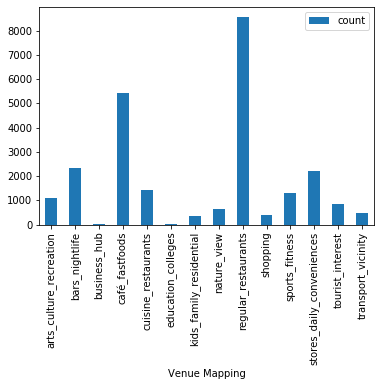

In [6]:
ax = venue_count.plot.bar(x='Venue Mapping', y='count')

In [7]:
venue_count['importance']=venue_count['count'].min()/venue_count['count']
venue_count

,Venue Mapping,count,importance
0,arts_culture_recreation,1086,0.023020
1,bars_nightlife,2324,0.010757
2,business_hub,28,0.892857
3,café_fastfoods,5406,0.004624
4,cuisine_restaurants,1440,0.017361
5,education_colleges,25,1.000000
6,kids_family_residential,369,0.067751
7,nature_view,630,0.039683
8,regular_restaurants,8542,0.002927
9,shopping,375,0.066667


In [8]:
venue_counts=venue_count.drop('count',1)
venue_counts_t=venue_counts.T
venue_counts_t.columns=venue_counts['Venue Mapping']
venue_counts_t.drop('Venue Mapping',inplace=True)
venue_counts_t

Venue Mapping,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
importance,0.0230203,0.0107573,0.892857,0.00462449,0.0173611,1,0.0677507,0.0396825,0.00292672,0.0666667,0.019084,0.0113688,0.0295508,0.0520833


In [9]:
city_onehot = pd.get_dummies(city_venue[['Venue Mapping']], prefix="", prefix_sep="")
#print(Toronto_onehot.head())
# add neighborhood column back to dataframe
city_onehot['Neighborhood'] = city_venue['Neighborhood'] 
# move neighborhood column to the first column
fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head().sort_values('Neighborhood',ascending=True)

,Neighborhood,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,Aarey Milk Colony,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,Aarey Milk Colony,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Aarey Milk Colony,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Aarey Milk Colony,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Aarey Milk Colony,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
## Grouping Neighborhoods by the sum of the venue_types

In [11]:
city_grouped = city_onehot.groupby('Neighborhood').sum().reset_index()
city_grouped

,Neighborhood,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,Aarey Milk Colony,5,6,1,10,2,0,1,1,20,1,3,7,1,0
1,Abhyudaya Nagar,6,12,1,15,7,0,0,1,30,3,4,9,4,1
2,Airoli,0,2,0,5,0,0,0,0,7,0,0,2,0,4
3,Alika Nagar,4,5,1,13,0,0,2,0,20,1,4,6,0,3
4,Ambedkar Nagar,3,14,0,22,12,1,2,2,18,0,7,10,0,1
5,Amboli,3,15,0,22,7,1,1,0,32,0,4,9,1,0
6,Amrut Nagar,2,13,0,19,7,0,1,2,29,3,8,9,3,0
7,Anand Nagar,3,8,0,24,6,0,3,4,31,0,5,11,4,0
8,Andheri (East),1,9,0,25,5,1,0,0,41,0,0,5,8,0
9,Andheri (West),3,19,0,22,7,0,1,2,29,0,0,6,2,0


In [12]:
# normalizing data  


#for k in range(1,15):
#    city_grouped[city_grouped.columns[k]]=(city_grouped[city_grouped.columns[k]]/city_grouped[city_grouped.columns[k]].max())
city_grouped.head()

,Neighborhood,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,Aarey Milk Colony,5,6,1,10,2,0,1,1,20,1,3,7,1,0
1,Abhyudaya Nagar,6,12,1,15,7,0,0,1,30,3,4,9,4,1
2,Airoli,0,2,0,5,0,0,0,0,7,0,0,2,0,4
3,Alika Nagar,4,5,1,13,0,0,2,0,20,1,4,6,0,3
4,Ambedkar Nagar,3,14,0,22,12,1,2,2,18,0,7,10,0,1


In [13]:
## function to return the top venues per neighborhood

In [14]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [15]:
num_top_venues = 5
city_group_common=city_grouped.drop('regular_restaurants',1).drop('café_fastfoods',1)
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = city_group_common['Neighborhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_group_common.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aarey Milk Colony,stores_daily_conveniences,bars_nightlife,arts_culture_recreation,sports_fitness,cuisine_restaurants
1,Abhyudaya Nagar,bars_nightlife,stores_daily_conveniences,cuisine_restaurants,arts_culture_recreation,tourist_interest
2,Airoli,transport_vicinity,stores_daily_conveniences,bars_nightlife,tourist_interest,sports_fitness
3,Alika Nagar,stores_daily_conveniences,bars_nightlife,sports_fitness,arts_culture_recreation,transport_vicinity
4,Ambedkar Nagar,bars_nightlife,cuisine_restaurants,stores_daily_conveniences,sports_fitness,arts_culture_recreation


In [16]:
city_grouped_clustering = city_grouped.drop(['Neighborhood'], 1)
city_grouped_clustering.head()

,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,5,6,1,10,2,0,1,1,20,1,3,7,1,0
1,6,12,1,15,7,0,0,1,30,3,4,9,4,1
2,0,2,0,5,0,0,0,0,7,0,0,2,0,4
3,4,5,1,13,0,0,2,0,20,1,4,6,0,3
4,3,14,0,22,12,1,2,2,18,0,7,10,0,1


In [17]:
city_grouped_clustering_analysis=city_grouped_clustering.multiply(venue_counts_t.values[0])
city_grouped_clustering_analysis.head()

,arts_culture_recreation,bars_nightlife,business_hub,café_fastfoods,cuisine_restaurants,education_colleges,kids_family_residential,nature_view,regular_restaurants,shopping,sports_fitness,stores_daily_conveniences,tourist_interest,transport_vicinity
0,0.115101,0.064544,0.892857,0.046245,0.034722,0.0,0.067751,0.039683,0.058534,0.066667,0.057252,0.079582,0.029551,0.000000
1,0.138122,0.129088,0.892857,0.069367,0.121528,0.0,0.000000,0.039683,0.087801,0.200000,0.076336,0.102319,0.118203,0.052083
2,0.000000,0.021515,0.000000,0.023122,0.000000,0.0,0.000000,0.000000,0.020487,0.000000,0.000000,0.022738,0.000000,0.208333
3,0.092081,0.053787,0.892857,0.060118,0.000000,0.0,0.135501,0.000000,0.058534,0.066667,0.076336,0.068213,0.000000,0.156250
4,0.069061,0.150602,0.000000,0.101739,0.208333,1.0,0.135501,0.079365,0.052681,0.000000,0.133588,0.113688,0.000000,0.052083


In [18]:
# dropping stores regular restaurants and cafes as they are quite abundant and available in each areas



distance=[]

kclusters= range(1,50)
for k in kclusters:
# run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(city_grouped_clustering)
    distance.append(kmeans.inertia_)

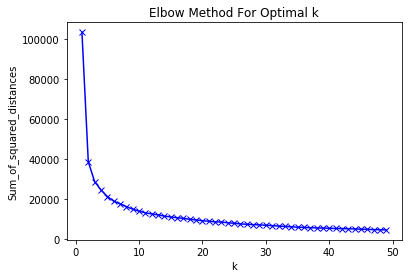

In [19]:
# Checking the elbow to find th emost desirable K-value

plt.plot(kclusters,distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [20]:
# selecting the number of clusters as 10

kclusters = 10


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)
 
#neighborhoods_venues_sorted.drop(['Cluster Labels'],axis=1,inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [21]:
# defining the final city data with cluster
city_final = city_venue

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
city_final = city_venue.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# 
city_plot=city_final[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude','Cluster Labels']].groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'],as_index=False).mean()
city_plot.sort_values(['Neighborhood','Cluster Labels'])

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels
0,Aarey Milk Colony,19.156129,72.870722,4
1,Abhyudaya Nagar,18.990477,72.844057,2
2,Airoli,19.158515,72.999402,0
3,Alika Nagar,19.198397,72.874267,4
4,Ambedkar Nagar,19.070822,72.828865,7
5,Amboli,19.132010,72.849864,3
6,Amrut Nagar,19.100845,72.911820,3
7,Anand Nagar,18.966523,72.811888,3
8,Andheri (East),19.115883,72.854202,6
9,Andheri (West),19.117249,72.833968,3


In [22]:
## Checking the distribution of the clusters

In [23]:
clusters=city_plot[['Neighborhood','Cluster Labels']].groupby(['Cluster Labels'],as_index=False).count().sort_values('Neighborhood',ascending=False)
clusters.sort_values('Cluster Labels')

,Cluster Labels,Neighborhood
0,0,62
1,1,27
2,2,29
3,3,43
4,4,35
5,5,39
6,6,40
7,7,30
8,8,30
9,9,32


In [24]:
# Checking the most common venue for each clusters

In [25]:

cluster_label_1=city_final[['Cluster Labels','1st Most Common Venue','Neighborhood']].groupby(['Cluster Labels','1st Most Common Venue'],as_index=False).count().sort_values(['Cluster Labels','Neighborhood'],ascending=False)

cluster_label_1.rename(columns={'1st Most Common Venue':'Common Venue'},inplace=True)
cluster_label_1.head()

,Cluster Labels,Common Venue,Neighborhood
43,9,stores_daily_conveniences,1910
42,9,sports_fitness,246
40,9,cuisine_restaurants,126
39,9,bars_nightlife,83
44,9,tourist_interest,78


In [26]:
cluster_label_2=city_final[['Cluster Labels','2nd Most Common Venue','Neighborhood']].groupby(['Cluster Labels','2nd Most Common Venue'],as_index=False).count().sort_values(['Cluster Labels','Neighborhood'],ascending=False)
cluster_label_2.rename(columns={'2nd Most Common Venue':'Common Venue'},inplace=True)
cluster_label_2.head()

,Cluster Labels,Common Venue,Neighborhood
57,9,tourist_interest,598
52,9,bars_nightlife,561
53,9,cuisine_restaurants,492
55,9,sports_fitness,409
56,9,stores_daily_conveniences,285


In [27]:
cluster_label_3=city_final[['Cluster Labels','3rd Most Common Venue','Neighborhood']].groupby(['Cluster Labels','3rd Most Common Venue'],as_index=False).count().sort_values(['Cluster Labels','Neighborhood'],ascending=False)
cluster_label_3.rename(columns={'3rd Most Common Venue':'Common Venue'},inplace=True)
cluster_label_3.head()

,Cluster Labels,Common Venue,Neighborhood
56,9,cuisine_restaurants,945
60,9,sports_fitness,585
55,9,bars_nightlife,285
58,9,nature_view,281
61,9,stores_daily_conveniences,248


In [28]:
cluster_label=pd.concat([cluster_label_1,cluster_label_2,cluster_label_3])
cluster_label=cluster_label.groupby(['Cluster Labels','Common Venue'],as_index=False).sum()
cluster_label

,Cluster Labels,Common Venue,Neighborhood
0,0,arts_culture_recreation,680
1,0,bars_nightlife,496
2,0,cuisine_restaurants,468
3,0,nature_view,240
4,0,shopping,52
5,0,sports_fitness,252
6,0,stores_daily_conveniences,1467
7,0,tourist_interest,398
8,0,transport_vicinity,1491
9,1,arts_culture_recreation,100


In [29]:
cluster_label_array= cluster_label_.values
fig = plt.figure(figsize=(20,10)) 
ax = plt.subplot()

space = .5

conditions = np.unique(cluster_label_array[:,0])
categories = np.unique(cluster_label_array[:,1])
#print(conditions)
#print(categories)
n = len(conditions)

width = (1 - space) / (len(conditions))
print ("width:", width)

for i,cat in enumerate(categories):
    vals=[0]*10
    val = cluster_label_array[cluster_label_array[:,1] == cat][:,2].astype(np.float)
    pos = [j - (1 - space) / 2. + i * width-.5 for j in range(1,n+1)]
    num=cluster_label_array[cluster_label_array[:,1] == cat][:,0]
    for k in range(0,len(num)):
        vals[num[k]]=val[k]
    ax.bar(pos,vals, width=width,label=cat,color=cm.hsv(float(i) / len(categories)))

xticks=np.arange(n)

xticks1=[",".join(item) for item in xticks.astype(str)]

ax.set_xticks(xticks)
ax.set_xlabel('Cluster')
ax.set_ylabel('No of venues')
ax.set_title('No of venues by cluster')
ax.grid(linestyle='-', linewidth='0.5',axis='x', color='red')
ax.legend()

NameError: name 'cluster_label_' is not defined

In [ ]:
data={0:'Chilled out Neighborhoods',
      1:'Places with nature/sea view and tourist attraction',
      2:'Low profile residential areas (far off)',
      3:'Hip and Happening',
      4:'Business Hubs and offices',
      5:'Good for post-retirement homes',
      6:'Low profile residential areas (suburbs)',
      7:'Open spaces for sports and fitness enthusiasts',
      8:'Posh Areas',
      9:'High Profile Residential Area',}

cluster_label_name= pd.Series(data).to_frame(name='label')
cluster_label_name


In [ ]:
# create map
latitude = city_plot['Neighborhood Latitude'].mean()
longitude = city_plot['Neighborhood Longitude'].mean()


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.tab10(np.linspace(0, 1, len(ys)))

col_scale = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_plot['Neighborhood Latitude'], city_plot['Neighborhood Longitude'], city_plot['Neighborhood'], city_plot['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7.5,
        popup=label,
        color=None,
        fill=True,
        fill_color=col_scale[cluster],
        fill_opacity=.8).add_to(map_clusters)

# Creating legend
for c in range(0,len(colors_array)):
    r=int(colors_array[c][0]*255)
    g=int(colors_array[c][1]*255)
    b=int(colors_array[c][2]*255)
    group =folium.FeatureGroup(name='<span style=\\"color:rgb({},{},{},{});\\">{}</span>'.format(r,g,b,1,str(c)+"-"+cluster_label_name.iloc[c]['label']))
    group.add_to(map_clusters)


folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)



map_clusters.save(outfile="clusters.html")

In [ ]:
city_final[['Cluster Labels','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue']].drop_duplicates().sort_values('Cluster Labels')

In [ ]:
(city_final[['Cluster Labels','1st Most Common Venue','Neighborhood']].groupby(['Cluster Labels','1st Most Common Venue'],as_index=False).count()).groupby(['Cluster Labels','1st Most Common Venue'],as_index=False).max()

In [ ]:
latitude = city_plot['Neighborhood Latitude'].mean()
longitude = city_plot['Neighborhood Longitude'].mean()


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)



city_data=pd.read_csv("https://raw.githubusercontent.com/girishtere/Applied-Data-Science-Capstone/master/Data/pp_latlong.csv")
city_pp=city_data[['Locality Name','buy_rate_avg','Latitude','Longitude']]
city_pp['price_label']=city_pp['Locality Name']+" -Rs."+city_pp['buy_rate_avg'].astype(str)+"/sq.ft"
city_pp.dropna(inplace=True)
city_plot2=city_pp[['Latitude','Longitude','buy_rate_avg']].dropna().groupby(['Latitude','Longitude'],as_index=False).mean()


HeatMap( list(zip(city_plot2.Latitude, city_plot2.Longitude, city_plot2['buy_rate_avg'])),
                   min_opacity=0.8,
                   max_val=45000,
                   radius=20, 
                   blur=50,
                   max_zoom=5, 
                 ).add_to(map_clusters)



#set color scheme for the clusters
x = np.arange(kclusters)

ys = [i + x + (i*x)**2 for i in range(kclusters)]

colors_array = cm.tab10(np.linspace(0, 1, len(ys)))

col_scale = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_plot['Neighborhood Latitude'], city_plot['Neighborhood Longitude'], city_plot['Neighborhood'], city_plot['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=None,
        fill=True,
        fill_color=col_scale[cluster],
        fill_opacity=1).add_to(map_clusters)

# Creating legend
for c in range(0,len(colors_array)):
    r=int(colors_array[c][0]*255)
    g=int(colors_array[c][1]*255)
    b=int(colors_array[c][2]*255)
    group =folium.FeatureGroup(name='<span style=\\"color:rgb({},{},{},{});\\">{}</span>'.format(r,g,b,1,str(c)+"-"+cluster_label_name.iloc[c]['label']))
    group.add_to(map_clusters)


folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)



map_clusters.save(outfile= "Final_map.html")